# Policy Gradients

## Torch

In [1]:
from policy_model import MultiLayerModel, Agent, BaselineAgent, PyTorchWrapper
from gymnasium import make
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

env_name = "LunarLander-v2"
# env_name = "CartPole-v1"

env = PyTorchWrapper(make(env_name), device)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
env.close()

Using device: cpu


### Standard REINFORCE

In [2]:
policy_model_layers = [64, 64]
policy_opt = torch.optim.Adam
policy_lr = 1e-2
policy_model = Agent(observation_space, action_space, policy_model_layers).to(device)

value_model_layers = [64, 64]
value_model = MultiLayerModel(observation_space, 1, value_model_layers, output_activation=None).to(device)

In [3]:
# Configuration
n_episodes = 5000
n_steps = 500
check_n = 30
gamma = 0.99

lr_policy = 0.01
policy_model.set_policy_learning_rate(lr_policy)
policy_model.reset()

env = PyTorchWrapper(make(env_name), device)

track_every = 25
ep_rewards = []
ep_steps = []

for i_episode in range(n_episodes):
    observation, _ = env.reset()
    ep_reward = 0

    for t in range(n_steps):
        action = policy_model.select_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        policy_model.store_reward(reward)
        ep_reward += reward
        if terminated or truncated:
            break

    ep_rewards.append(ep_reward)
    ep_steps.append(t)

    policy_model.update_parameters(gamma)
    if (i_episode+1) % track_every == 0:
        print(f"Episode {i_episode-track_every}-{i_episode} | mean reward: {round(sum(ep_rewards[-track_every:])/track_every,2)}, mean steps: {sum(ep_steps[-track_every:])/track_every}")


Episode -1-24 | mean reward: -204.37, mean steps: 88.6
Episode 24-49 | mean reward: -151.46, mean steps: 88.68
Episode 49-74 | mean reward: -133.73, mean steps: 89.24
Episode 74-99 | mean reward: -265.5, mean steps: 147.92
Episode 99-124 | mean reward: -208.11, mean steps: 96.48
Episode 124-149 | mean reward: -155.38, mean steps: 103.12
Episode 149-174 | mean reward: -91.17, mean steps: 143.44
Episode 174-199 | mean reward: -24.48, mean steps: 133.04
Episode 199-224 | mean reward: -201.52, mean steps: 227.16
Episode 224-249 | mean reward: -77.37, mean steps: 141.32
Episode 249-274 | mean reward: -41.71, mean steps: 92.92
Episode 274-299 | mean reward: -77.29, mean steps: 224.4
Episode 299-324 | mean reward: -95.28, mean steps: 340.08
Episode 324-349 | mean reward: 5.83, mean steps: 403.6
Episode 349-374 | mean reward: 27.64, mean steps: 279.0
Episode 374-399 | mean reward: -63.97, mean steps: 192.24
Episode 399-424 | mean reward: -28.42, mean steps: 162.28
Episode 424-449 | mean reward

KeyboardInterrupt: 

### Baseline REINFORCE

In [6]:
## Agent Defn
model_layers = [128, 64]
model = BaselineAgent(observation_space, action_space, model_layers).to(device)

In [7]:
# Configuration
n_episodes = 5000
n_steps = 500
check_n = 30
gamma = 0.99

policy_lr = 0.001
value_lr = 0.01
model.set_policy_learning_rate(policy_lr)
model.set_value_learning_rate(value_lr)
model.reset()

env = PyTorchWrapper(make(env_name), device)

track_every = 25
ep_rewards = []
ep_steps = []

for i_episode in range(n_episodes):
    observation, _ = env.reset()
    ep_reward = 0

    for t in range(n_steps):
        action = model.select_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        model.store_reward(reward)
        ep_reward += reward
        if terminated or truncated:
            break

    # Update parameters
    model.update_parameters(gamma)

    ep_rewards.append(ep_reward)
    ep_steps.append(t)
    if (i_episode+1) % track_every == 0:
        print(f"Episode {i_episode-track_every}-{i_episode} | mean reward: {round(sum(ep_rewards[-track_every:])/track_every,2)}, mean steps: {sum(ep_steps[-track_every:])/track_every}")


Episode -1-24 | mean reward: -204.82, mean steps: 92.76
Episode 24-49 | mean reward: -206.36, mean steps: 88.88
Episode 49-74 | mean reward: -161.58, mean steps: 91.56
Episode 74-99 | mean reward: -151.65, mean steps: 98.56
Episode 99-124 | mean reward: -171.49, mean steps: 94.4
Episode 124-149 | mean reward: -152.22, mean steps: 87.56
Episode 149-174 | mean reward: -143.48, mean steps: 94.96
Episode 174-199 | mean reward: -147.39, mean steps: 84.48
Episode 199-224 | mean reward: -129.75, mean steps: 91.4
Episode 224-249 | mean reward: -123.55, mean steps: 98.72
Episode 249-274 | mean reward: -124.43, mean steps: 93.56
Episode 274-299 | mean reward: -112.36, mean steps: 106.76
Episode 299-324 | mean reward: -110.45, mean steps: 102.96
Episode 324-349 | mean reward: -92.5, mean steps: 104.44
Episode 349-374 | mean reward: -109.76, mean steps: 112.72
Episode 374-399 | mean reward: -110.92, mean steps: 154.56
Episode 399-424 | mean reward: -73.81, mean steps: 148.64
Episode 424-449 | mean

Traceback (most recent call last):
  File "c:\Users\jimdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jimdi\AppData\Local\Temp\ipykernel_13924\686114058.py", line 24, in <module>
    action = model.select_action(observation)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jimdi\Documents\workspace\coding-exercises\policy-gradient\policy_model.py", line 117, in select_action
    self.value_optimizer = value_optimizer(self.value_model.parameters(), lr=value_lr)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jimdi\Documents\workspace\coding-exercises\policy-gradient\policy_model.py", line 71, in select_action
  File "c:\Users\jimdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\distributions\categorical.py", line 70, in __init__
    super().__init__(batch_shape, validate_args=validate_args)
  File "c:\Use

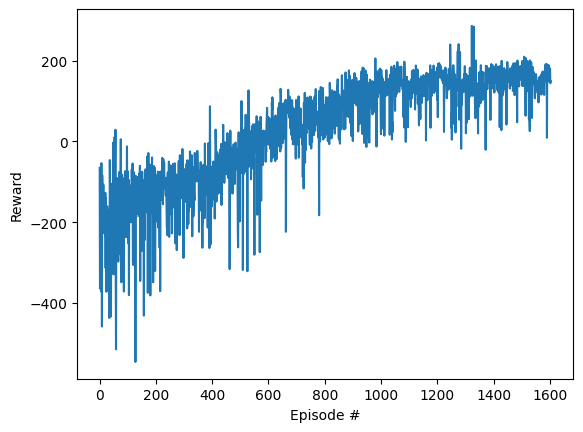

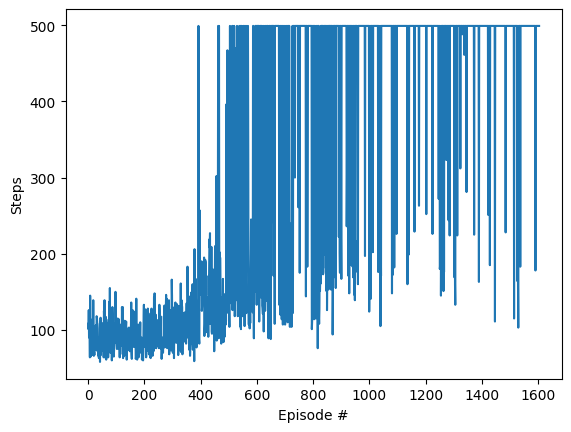

In [10]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(ep_rewards)), ep_rewards)
plt.ylabel('Reward')
plt.xlabel('Episode #')
plt.show()

plt.plot(np.arange(len(ep_steps)), ep_steps)
plt.ylabel('Steps')
plt.xlabel('Episode #')
plt.show()


In [8]:
# Save torch model
model.save(env_name)

AttributeError: 'BaselineAgent' object has no attribute 'save'